# Matrix Factorization Technique Using Surprise Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
from scipy.sparse import csr_matrix
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [6]:
dataframe = pd.read_csv('final_dataframe.csv')

In [7]:
dataframe.head()

,user_id,song_id,freq,track_id,artist_name,release,song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,You're The One - Dwight Yoakam
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim,Tive Sim - Cartola
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero,El Cuatrero - Miguel Calo


In [8]:
# Get how many songs each user have listened to
user_counts = dataframe.groupby('user_id')['song_id'].count()

# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()
# Filtered the dataset to keep only those users with more than 16 listened
# Get how many user have listened to each song
song_counts = dataframe.groupby('song_id')['user_id'].count()

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()
df_song_reduced = dataframe[(dataframe['user_id'].isin(user_ten_id)) & (dataframe['song_id'].isin(song_ten_id))].reset_index(drop=True)

Matrix Factorization is a powerful way to implement a recommendation system. The idea behind it is to represent users and items in a lower-dimensional latent space.

So, in other words, Matrix factorization methods decompose the original sparse user-item matrix into lower dimensionality less sparse rectangular matrices with latent features.

This does not only solve the sparsity issue but also makes the method scalable. It doesn't matter how big the matrix is, you can always find lower dimensionality matrices that are a true representation of the original one.

Among the different matrix factorization techniques, we found the popular singular value decomposition (SVD).

This can be an abstract concept as we deepen into the mathematical foundations. But we'll try to keep it as simple as possible. Imagine we have a matrix A that contains the data for n users x m songs. This matrix can be decomposed uniquely into 3 matrices; let's called them U, S, and V.

In terms of our song recommender:

     - U is an n users x r user-latent feature matrix
     - V is an m songs x r song-latent feature matrix
     - S is an r x r non-negative diagonal matrix containing the singular values of the original    matrix.
Instead of working with the implicit rating as it is, we'll apply the binning technique. 

We'll define 10 categories. The original data values which fall into the interval from 0 to 1, will be replaced by the representative rating of 1; if they fall into the interval 1 to 2, they will be replaced by 2; and so on and so forth. The last category will be assigned to original values ranging from 9 to 2213.

Instead of working with the implicit rating as it is, we'll apply the binning technique. 

We'll define 10 categories. The original data values which fall into the interval from 0 to 1, will be replaced by the representative rating of 1; if they fall into the interval 1 to 2, they will be replaced by 2; and so on and so forth. The last category will be assigned to original values ranging from 9 to 2213.

In [9]:
df_song_reduced.shape

(157456, 7)

In [10]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]
df_song_reduced['freq'] = pd.cut(df_song_reduced['freq'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
freqs = pd.DataFrame(df_song_reduced.groupby('freq').size(), columns=['count']).reset_index(drop=False)

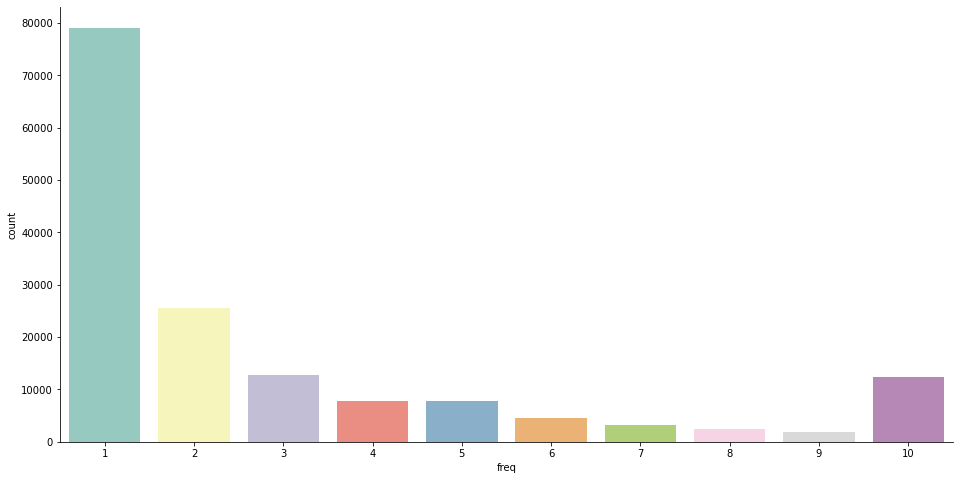

In [11]:
import seaborn as sns
plt.figure(figsize=(16, 8))
sns.barplot(x='freq', y='count', palette='Set3', data=freqs)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [12]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'freq']], reader)

In [13]:
trainset, testset = train_test_split(data, test_size=.25)

We'll use the built-in function for SVD. First, a set of parameters is going to be defined to search for the best parameters for the model.

The GridSearchCV class will compute accuracy metrics for the SVDalgorithm on the combinations of parameters selected, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm.

In [14]:
param_grid = {'n_factors': [160], 
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)
# find the best parameters for the model
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  12 | elapsed:  3.0min remaining:  9.1min
[Parallel(n_jobs=-2)]: Done   7 out of  12 | elapsed:  4.9min remaining:  3.5min


2.3705870858801905
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  6.0min finished


In [15]:
# Perform the cross validation
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.3420  2.3156  2.3305  2.2965  2.3151  2.3199  0.0154  
Fit time          55.97   51.77   64.45   54.71   58.06   56.99   4.25    
Test time         0.20    0.22    0.21    0.20    0.22    0.21    0.01    


{'test_rmse': array([2.34204391, 2.31558355, 2.33045477, 2.29654037, 2.31510147]),
 'fit_time': (55.96609568595886,
  51.774779319763184,
  64.4461567401886,
  54.706645488739014,
  58.05871081352234),
 'test_time': (0.204833984375,
  0.22028279304504395,
  0.21200799942016602,
  0.19944143295288086,
  0.22037816047668457)}

After finding the best parameters for the model, we create our final model, train it and find the error for the test set.

In [16]:
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")


RMSE: 2.3299
The RMSE is 2.3299359338334398


In [19]:
#Now we will predict.

In [18]:
# pick a song
song = df_song_reduced['release'].iloc[220]
# pick an user
user = df_song_reduced['user_id'].iloc[1]

# get the prediction
prediction = final_algorithm.predict(1, 220)

# print prediction
print(f"The estimate rating that the user {user} will give to the song {song} is {round(prediction.est, 2)}")

The estimate rating that the user 0b254c684efb08fd04933add2d1e4191d2a87bac will give to the song Like A Boss is 2.86
